# Phase Analysis with Real Data

This notebook tests phase analysis methods using real experimental data loaded from NAS.

## Data Sources:
- **Primary**: Data loaded from NAS using `NAS_DB` and `VEST_DB` controllers
- **Fallback**: HDF5 files from `results/` directory (saved analysis results)

## Workflow:
1. Load data from NAS for the specified shot number
2. Process data (refine, remove offset)
3. Save processed data to HDF5 in `results/` directory
4. Test phase analysis methods on the loaded data

## Test Methods:
- SignalStacker: CDM and CORDIC phase difference
- STFTRidgeAnalyzer: STFT-based ridge detection
- CWTPhaseReconstructor: CWT-based phase reconstruction

## Usage:
1. Set the `shot_num` variable to your desired shot number
2. Run cells sequentially - data will be loaded from NAS and saved to results
3. Inspect results and phase analysis outputs


In [1]:
# Setup and imports
import sys
from pathlib import Path
import os

# Configure Numba threading layer for parallel execution
os.environ['NUMBA_THREADING_LAYER'] = 'omp'

# Add project root to path
current_dir = Path.cwd()
ifi_root = current_dir.parent if current_dir.name == "analysis" else current_dir
sys.path.insert(0, str(ifi_root))

from ifi.utils.cache_setup import setup_project_cache
cache_config = setup_project_cache()
print(f"Cache configured: {cache_config['cache_dir']}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# Import Numba config after setting environment variable
try:
    import numba
    try:
        numba.config.THREADING_LAYER = 'omp'
        print(f"Numba threading layer: {numba.config.THREADING_LAYER}")
    except Exception as e:
        print(f"Warning: Could not set Numba threading layer: {e}")
        print("Falling back to default threading layer")
except ImportError:
    print("Warning: Numba not available")

from ifi.utils.file_io import load_results_from_hdf5, save_results_to_hdf5
from ifi.analysis.phase_analysis import (
    SignalStacker,
    STFTRidgeAnalyzer,
    CWTPhaseReconstructor,
    PhaseChangeDetector,
)
from ifi.analysis.phi2ne import get_interferometry_params

print("✓ All imports successful")


Using cache directory: C:\Users\dhkdw\Documents\mygit\ifi\cache\numba_cache
Project cache configured successfully.
Cache configured: C:\Users\dhkdw\Documents\mygit\ifi\cache\numba_cache
Numba threading layer: omp
✓ All imports successful


## 1. Data Loading

Load real experimental data from HDF5 files or CSV files.


In [2]:
# Configuration: Set your shot number here
shot_num = 45821  # Change this to your shot number
results_base_dir = "results"  # Base directory for HDF5 results
config_path = "ifi/config.ini"  # Path to config file

print("=" * 80)
print(f"Loading data for shot {shot_num} from NAS")
print("=" * 80)

# Initialize database controllers
from ifi.db_controller.nas_db import NAS_DB
from ifi.db_controller.vest_db import VEST_DB
from ifi.analysis import processing

try:
    nas_db = NAS_DB(config_path=config_path)
    vest_db = VEST_DB(config_path=config_path)
    print("✓ Database controllers initialized")
except Exception as e:
    print(f"✗ Failed to initialize database controllers: {e}")
    raise

# Find files for the shot
print(f"\nSearching for files for shot {shot_num}...")
target_files = nas_db.find_files(
    query=[shot_num],
    data_folders=None,
    add_path=False,
    force_remote=False,
)

if not target_files:
    print(f"⚠ No files found for shot {shot_num}")
    print("Trying to load from existing HDF5 results...")
    h5_results = load_results_from_hdf5(shot_num, base_dir=results_base_dir)
    if h5_results and "signals" in h5_results:
        print(f"✓ Loaded data from existing HDF5 file")
        signals = h5_results["signals"]
        metadata = h5_results.get("metadata", {})
        fs = metadata.get("sampling_frequency", 50e6)
        print(f"Sampling frequency: {fs/1e6:.1f} MHz")
    else:
        raise ValueError(f"No data found for shot {shot_num}")
else:
    print(f"✓ Found {len(target_files)} file(s)")
    for f in target_files:
        print(f"  - {Path(f).name}")
    
    # Load and process data from NAS
    print(f"\nLoading and processing data from NAS...")
    signals = {}
    stft_results = {}
    cwt_results = {}
    
    for file_path in target_files:
        print(f"\nProcessing: {Path(file_path).name}")
        
        # Load data from NAS
        data_dict = nas_db.get_shot_data(file_path, force_remote=False)
        if not data_dict or file_path not in data_dict:
            print(f"  ⚠ Failed to load {Path(file_path).name}, skipping...")
            continue
        
        df_raw = data_dict[file_path]
        print(f"  ✓ Loaded raw data: shape {df_raw.shape}, columns: {list(df_raw.columns)}")
        
        # Refine data (remove NaN values)
        df_refined = processing.refine_data(df_raw)
        print(f"  ✓ Data refined: shape {df_refined.shape}")
        
        # Remove offset
        df_processed = processing.remove_offset(df_refined, window_size=2001)
        print(f"  ✓ Offset removed")
        
        # Store processed signal
        signals[Path(file_path).name] = df_processed
        
        # Calculate sampling frequency from TIME column
        if "TIME" in df_processed.columns:
            time_diff = df_processed["TIME"].diff().mean()
            if pd.notna(time_diff) and time_diff > 0:
                fs = 1 / time_diff
                print(f"  ✓ Sampling frequency: {fs/1e6:.1f} MHz")
            else:
                fs = 50e6  # Default
                print(f"  ⚠ Could not determine sampling frequency, using default: {fs/1e6:.1f} MHz")
        else:
            fs = 50e6  # Default
            print(f"  ⚠ No TIME column found, using default sampling frequency: {fs/1e6:.1f} MHz")
    
    if not signals:
        raise ValueError("No signals were successfully loaded from NAS")
    
    # Load VEST data
    print(f"\nLoading VEST data for shot {shot_num}...")
    vest_data_dict = vest_db.load_shot(shot=shot_num, fields=[])
    if vest_data_dict:
        vest_data = pd.DataFrame(vest_data_dict)
        print(f"  ✓ Loaded VEST data: shape {vest_data.shape}")
    else:
        vest_data = pd.DataFrame()
        print(f"  ⚠ No VEST data available")
    
    # Prepare density data (empty for now, will be calculated later if needed)
    density_data = pd.DataFrame()
    
    # Save results to HDF5
    print(f"\n" + "=" * 80)
    print(f"Saving results to HDF5...")
    print("=" * 80)
    
    results_dir = Path(results_base_dir) / str(shot_num)
    saved_path = save_results_to_hdf5(
        str(results_dir),
        shot_num,
        signals,
        stft_results,
        cwt_results,
        density_data,
        vest_data,
    )
    
    if saved_path:
        print(f"✓ Results saved to: {saved_path}")
        
        # Load saved results for verification
        h5_results = load_results_from_hdf5(shot_num, base_dir=results_base_dir)
        if h5_results and "signals" in h5_results:
            print(f"✓ Verified: Data can be loaded from saved HDF5 file")
            signals = h5_results["signals"]
            metadata = h5_results.get("metadata", {})
            fs = metadata.get("sampling_frequency", fs)
            print(f"  Sampling frequency: {fs/1e6:.1f} MHz")
        else:
            print(f"⚠ Warning: Could not verify saved data")
    else:
        print(f"⚠ Warning: Failed to save results to HDF5")
    
    print(f"\n✓ Data loading and saving complete")
    print(f"  Available signals: {list(signals.keys())}")
    for signal_name, signal_df in signals.items():
        print(f"    - {signal_name}: shape {signal_df.shape}, columns: {list(signal_df.columns)}")


Loading data for shot 45821 from NAS
✓ Database controllers initialized

Searching for files for shot 45821...
✓ Found 3 file(s)
  - 45821_056.csv
  - 45821_789.csv
  - 45821_ALL.csv

Loading and processing data from NAS...

Processing: 45821_056.csv
  ✓ Loaded raw data: shape (10000000, 4), columns: ['TIME', 'CH0', 'CH1', 'CH2']
  ✓ Data refined: shape (10000000, 4)
  ✓ Offset removed
  ✓ Sampling frequency: 250.0 MHz

Processing: 45821_789.csv
  ✓ Loaded raw data: shape (10000000, 4), columns: ['TIME', 'CH0', 'CH1', 'CH2']
  ✓ Data refined: shape (10000000, 4)
  ✓ Offset removed
  ✓ Sampling frequency: 250.0 MHz

Processing: 45821_ALL.csv
  ✓ Loaded raw data: shape (10000000, 4), columns: ['TIME', 'CH0', 'CH1', 'CH2']
  ✓ Data refined: shape (10000000, 4)
  ✓ Offset removed
  ✓ Sampling frequency: 250.0 MHz

Loading VEST data for shot 45821...
  ⚠ No VEST data available

Saving results to HDF5...
Results saved to: results\45821\45821.h5
✓ Results saved to: results\45821\45821.h5
Load

In [3]:
# This cell is intentionally left empty
# Data loading is handled in Cell 3 above


## 2. Signal Preparation

Extract reference and probe signals from loaded data.



Using signal file: 45821_056.csv
Signal dataframe shape: (10000000, 4)
Available columns: ['CH0', 'CH1', 'CH2', 'TIME']

Interferometry parameters:
  method: CDM
  freq: 94000000000.0
  freq_ghz: 94.0
  ref_col: CH0
  probe_cols: ['CH1', 'CH2']
  n_path: 2

✓ Signal extraction:
  Reference signal (CH0): 10000000 samples
  Probe signal (CH1): 10000000 samples
  Fundamental frequency: 94.00 GHz
  Sampling frequency: 250.0 MHz
  Signal duration: 40.00 ms


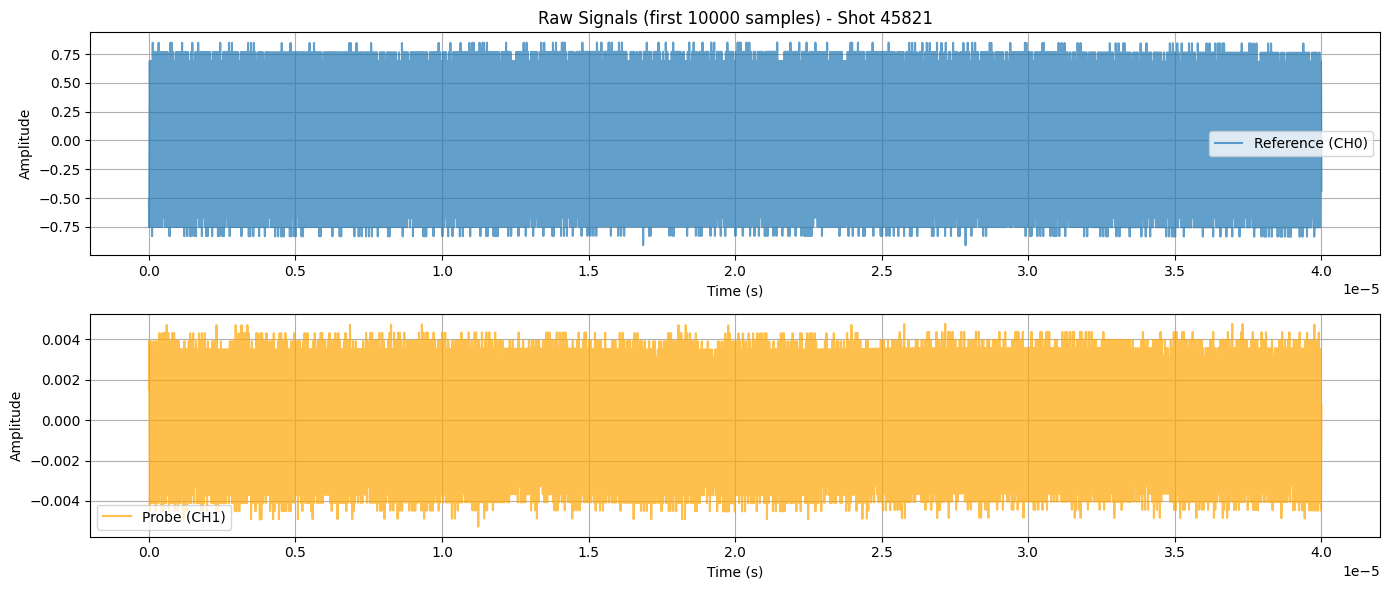


✓ Signal preparation complete


In [4]:
# Extract signals from the first available signal file
signal_name = list(signals.keys())[0]
signal_df = signals[signal_name]

print(f"\nUsing signal file: {signal_name}")
print(f"Signal dataframe shape: {signal_df.shape}")
print(f"Available columns: {list(signal_df.columns)}")

# Get interferometry parameters
try:
    # Try to get from saved metadata if available
    if 'h5_results' in locals() and h5_results and "metadata" in h5_results:
        params = h5_results["metadata"].get("interferometry_params", {})
        if not params:
            params = get_interferometry_params(shot_num, signal_name)
    else:
        params = get_interferometry_params(shot_num, signal_name)
except Exception as e:
    print(f"⚠ Warning: Could not get interferometry params from metadata: {e}")
    params = get_interferometry_params(shot_num, signal_name)

print(f"\nInterferometry parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Extract reference and probe signals
ref_col = params.get("ref_col", "CH0")
probe_cols = params.get("probe_cols", ["CH1"])
f0 = params.get("freq", 94e9)  # Default: 94 GHz

if ref_col not in signal_df.columns:
    print(f"\n⚠ Reference column '{ref_col}' not found. Available columns: {list(signal_df.columns)}")
    # Try to find CH0 or first column
    if "CH0" in signal_df.columns:
        ref_col = "CH0"
    else:
        ref_col = signal_df.columns[0]
    print(f"Using '{ref_col}' as reference signal")

if not probe_cols or probe_cols[0] not in signal_df.columns:
    print(f"\n⚠ Probe column '{probe_cols[0] if probe_cols else 'None'}' not found. Available columns: {list(signal_df.columns)}")
    # Try to find CH1 or second column
    if "CH1" in signal_df.columns:
        probe_cols = ["CH1"]
    else:
        probe_cols = [signal_df.columns[1] if len(signal_df.columns) > 1 else signal_df.columns[0]]
    print(f"Using '{probe_cols[0]}' as probe signal")

ref_signal = signal_df[ref_col].values
probe_signal = signal_df[probe_cols[0]].values

print(f"\n✓ Signal extraction:")
print(f"  Reference signal ({ref_col}): {len(ref_signal)} samples")
print(f"  Probe signal ({probe_cols[0]}): {len(probe_signal)} samples")
print(f"  Fundamental frequency: {f0/1e9:.2f} GHz")
print(f"  Sampling frequency: {fs/1e6:.1f} MHz")
print(f"  Signal duration: {len(ref_signal)/fs*1000:.2f} ms")

# Check for NaN or invalid values
ref_nan_count = np.sum(np.isnan(ref_signal))
probe_nan_count = np.sum(np.isnan(probe_signal))

if ref_nan_count > 0 or probe_nan_count > 0:
    print(f"\n⚠ Warning: NaN values detected")
    print(f"  Reference signal: {ref_nan_count} NaN values")
    print(f"  Probe signal: {probe_nan_count} NaN values")
    
    # Remove NaN values (forward fill)
    ref_signal = pd.Series(ref_signal).fillna(method='ffill').fillna(method='bfill').values
    probe_signal = pd.Series(probe_signal).fillna(method='ffill').fillna(method='bfill').values
    print(f"  ✓ NaN values handled (forward/backward fill)")

# Visualize raw signals
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
time_axis = np.arange(len(ref_signal)) / fs
# Show first 10000 samples or full signal if shorter
n_samples_show = min(10000, len(ref_signal))
plt.plot(time_axis[:n_samples_show], ref_signal[:n_samples_show], label=f"Reference ({ref_col})", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Raw Signals (first {n_samples_show} samples) - Shot {shot_num}")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_axis[:n_samples_show], probe_signal[:n_samples_show], label=f"Probe ({probe_cols[0]})", alpha=0.7, color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n✓ Signal preparation complete")


## 3. Phase Analysis with SignalStacker

Test CDM and CORDIC methods for phase difference calculation.


SignalStacker Phase Analysis

Detected fundamental frequency: 20.0000 MHz
Expected frequency: 94000.0000 MHz
Difference: 93980.0000 MHz
⚠ Using expected frequency (detected frequency seems incorrect)

--------------------------------------------------------------------------------
CDM Method
--------------------------------------------------------------------------------
✗ CDM method failed: Fundamental frequency 94000000000.00 Hz exceeds Nyquist frequency 125000000.00 Hz. Signal must be sampled at least 2x the highest frequency component.

--------------------------------------------------------------------------------
CORDIC Method
--------------------------------------------------------------------------------


Traceback (most recent call last):
  File "C:\Users\dhkdw\AppData\Local\Temp\ipykernel_31364\2335902347.py", line 33, in <module>
    phase_diff_cdm, f0_cdm = signal_stacker.compute_phase_difference_cdm(
  File "c:\Users\dhkdw\Documents\mygit\ifi\ifi\analysis\phase_analysis.py", line 808, in compute_phase_difference_cdm
    raise ValueError(
ValueError: Fundamental frequency 94000000000.00 Hz exceeds Nyquist frequency 125000000.00 Hz. Signal must be sampled at least 2x the highest frequency component.


✓ CORDIC phase difference calculated
  Time points: 10000000 samples
  Phase difference length: 10000000 samples
  Mean: -0.0062 rad (-0.36 deg)
  Std: 0.1294 rad
  Range: [-0.6932, 0.7192] rad
  Detected frequency: 94000.0000 MHz


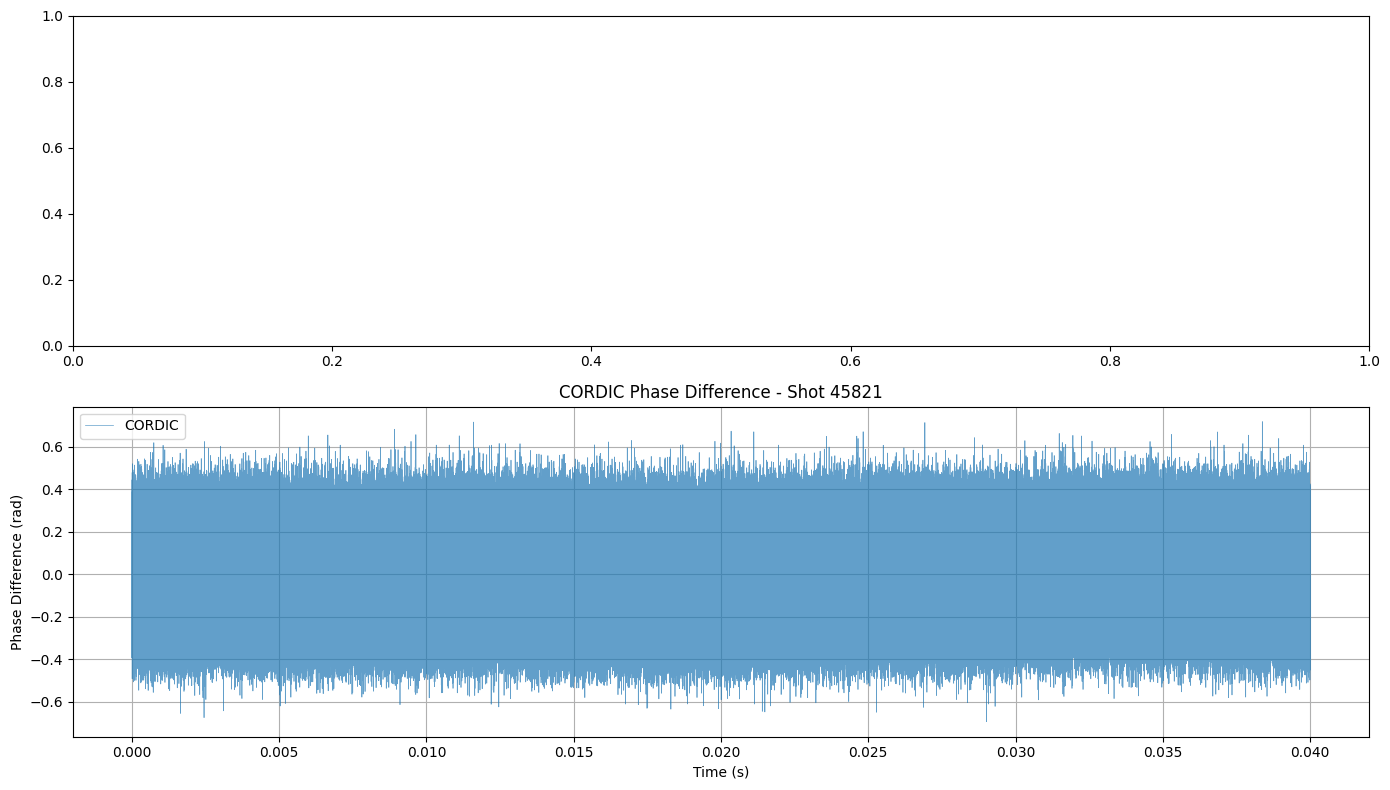


✓ SignalStacker analysis complete


In [5]:
# Initialize SignalStacker
signal_stacker = SignalStacker(fs)

print("=" * 80)
print("SignalStacker Phase Analysis")
print("=" * 80)

# Detect fundamental frequency
try:
    f0_detected = signal_stacker.find_fundamental_frequency(ref_signal)
    print(f"\nDetected fundamental frequency: {f0_detected/1e6:.4f} MHz")
    print(f"Expected frequency: {f0/1e6:.4f} MHz")
    print(f"Difference: {abs(f0_detected - f0)/1e6:.4f} MHz")
    
    # Use detected frequency if it's reasonable
    if abs(f0_detected - f0) / f0 < 0.2:  # Within 20%
        f0_use = f0_detected
        print(f"✓ Using detected frequency")
    else:
        f0_use = f0
        print(f"⚠ Using expected frequency (detected frequency seems incorrect)")
except Exception as e:
    print(f"⚠ Frequency detection failed: {e}")
    f0_use = f0
    print(f"Using expected frequency: {f0_use/1e6:.4f} MHz")

# Test CDM method
print("\n" + "-" * 80)
print("CDM Method")
print("-" * 80)

try:
    phase_diff_cdm, f0_cdm = signal_stacker.compute_phase_difference_cdm(
        ref_signal, probe_signal, f0_use
    )
    
    print(f"✓ CDM phase difference calculated")
    print(f"  Length: {len(phase_diff_cdm)} samples")
    print(f"  Mean: {np.mean(phase_diff_cdm):.4f} rad ({np.mean(phase_diff_cdm)*180/np.pi:.2f} deg)")
    print(f"  Std: {np.std(phase_diff_cdm):.4f} rad")
    print(f"  Range: [{np.min(phase_diff_cdm):.4f}, {np.max(phase_diff_cdm):.4f}] rad")
    print(f"  Detected frequency: {f0_cdm/1e6:.4f} MHz")
    
    cdm_success = True
except Exception as e:
    print(f"✗ CDM method failed: {e}")
    import traceback
    traceback.print_exc()
    phase_diff_cdm = None
    cdm_success = False

# Test CORDIC method
print("\n" + "-" * 80)
print("CORDIC Method")
print("-" * 80)

try:
    times_cordic, phase_diff_cordic, f0_cordic = signal_stacker.compute_phase_difference_cordic(
        ref_signal, probe_signal, f0_use
    )
    
    print(f"✓ CORDIC phase difference calculated")
    print(f"  Time points: {len(times_cordic)} samples")
    print(f"  Phase difference length: {len(phase_diff_cordic)} samples")
    print(f"  Mean: {np.mean(phase_diff_cordic):.4f} rad ({np.mean(phase_diff_cordic)*180/np.pi:.2f} deg)")
    print(f"  Std: {np.std(phase_diff_cordic):.4f} rad")
    print(f"  Range: [{np.min(phase_diff_cordic):.4f}, {np.max(phase_diff_cordic):.4f}] rad")
    print(f"  Detected frequency: {f0_cordic/1e6:.4f} MHz")
    
    cordic_success = True
except Exception as e:
    print(f"✗ CORDIC method failed: {e}")
    import traceback
    traceback.print_exc()
    times_cordic = None
    phase_diff_cordic = None
    cordic_success = False

# Visualize phase differences
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

if cdm_success and phase_diff_cdm is not None:
    time_cdm = np.arange(len(phase_diff_cdm)) / fs
    axes[0].plot(time_cdm, phase_diff_cdm, label="CDM", alpha=0.7, linewidth=0.5)
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Phase Difference (rad)")
    axes[0].set_title(f"CDM Phase Difference - Shot {shot_num}")
    axes[0].legend()
    axes[0].grid(True)

if cordic_success and phase_diff_cordic is not None:
    axes[1].plot(times_cordic, phase_diff_cordic, label="CORDIC", alpha=0.7, linewidth=0.5)
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Phase Difference (rad)")
    axes[1].set_title(f"CORDIC Phase Difference - Shot {shot_num}")
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\n✓ SignalStacker analysis complete")


## 4. Phase Analysis with STFTRidgeAnalyzer

Test STFT-based ridge detection and phase extraction.


In [6]:
# Initialize STFTRidgeAnalyzer
stft_analyzer = STFTRidgeAnalyzer(fs)

print("=" * 80)
print("STFT Ridge Analyzer Phase Analysis")
print("=" * 80)

try:
    t_common, ref_phases, probe_phases = stft_analyzer.compute_phase_difference(
        ref_signal, probe_signal, f0_use
    )
    
    phase_diff_stft = probe_phases - ref_phases
    
    print(f"✓ STFT phase difference calculated")
    print(f"  Common time points: {len(t_common)} samples")
    print(f"  Reference phases length: {len(ref_phases)} samples")
    print(f"  Probe phases length: {len(probe_phases)} samples")
    print(f"  Phase difference mean: {np.mean(phase_diff_stft):.4f} rad ({np.mean(phase_diff_stft)*180/np.pi:.2f} deg)")
    print(f"  Phase difference std: {np.std(phase_diff_stft):.4f} rad")
    print(f"  Range: [{np.min(phase_diff_stft):.4f}, {np.max(phase_diff_stft):.4f}] rad")
    
    stft_success = True
except Exception as e:
    print(f"✗ STFT method failed: {e}")
    import traceback
    traceback.print_exc()
    t_common = None
    phase_diff_stft = None
    stft_success = False

# Visualize STFT phase difference
if stft_success and phase_diff_stft is not None:
    plt.figure(figsize=(14, 6))
    plt.plot(t_common, phase_diff_stft, label="STFT", alpha=0.7, linewidth=0.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Phase Difference (rad)")
    plt.title(f"STFT Phase Difference - Shot {shot_num}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n✓ STFT analysis complete")


STFT Ridge Analyzer Phase Analysis
✗ STFT method failed: attempt to get argmax of an empty sequence

✓ STFT analysis complete


Traceback (most recent call last):
  File "C:\Users\dhkdw\AppData\Local\Temp\ipykernel_31364\1166154295.py", line 9, in <module>
    t_common, ref_phases, probe_phases = stft_analyzer.compute_phase_difference(
  File "c:\Users\dhkdw\Documents\mygit\ifi\ifi\analysis\phase_analysis.py", line 1395, in compute_phase_difference
    f_ref, t_ref, ridge_freqs_ref = self.compute_stft_with_ridge(ref_signal, f0)
  File "c:\Users\dhkdw\Documents\mygit\ifi\ifi\analysis\phase_analysis.py", line 1341, in compute_stft_with_ridge
    ridge_idx = np.argmax(np.abs(Sxx_band), axis=0)
  File "c:\Users\dhkdw\Documents\mygit\ifi\.venv\lib\site-packages\numpy\_core\fromnumeric.py", line 1342, in argmax
    return _wrapfunc(a, 'argmax', axis=axis, out=out, **kwds)
  File "c:\Users\dhkdw\Documents\mygit\ifi\.venv\lib\site-packages\numpy\_core\fromnumeric.py", line 57, in _wrapfunc
    return bound(*args, **kwds)
ValueError: attempt to get argmax of an empty sequence


## 5. Phase Analysis with CWTPhaseReconstructor

Test CWT-based phase reconstruction.


CWT Phase Reconstructor Analysis
✓ CWT phase difference calculated
  Common time points: 2500000 samples
  Reference phases length: 2500000 samples
  Probe phases length: 2500000 samples
  Phase difference mean: 8280.8789 rad (474459.41 deg)
  Phase difference std: 7919.5986 rad
  Range: [-7690.5625, 24250.5000] rad


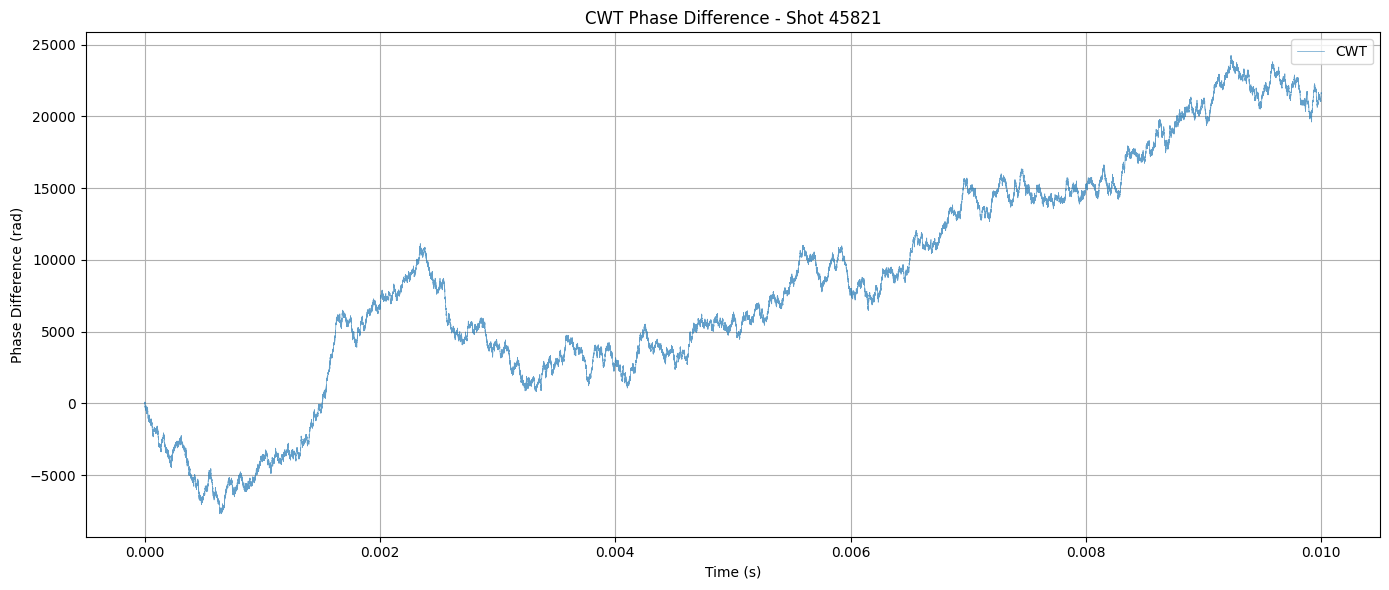


✓ CWT analysis complete


In [7]:
# Initialize CWTPhaseReconstructor
cwt_reconstructor = CWTPhaseReconstructor(fs)

print("=" * 80)
print("CWT Phase Reconstructor Analysis")
print("=" * 80)

try:
    t_cwt, ref_phases_cwt, probe_phases_cwt = cwt_reconstructor.compute_phase_difference(
        ref_signal, probe_signal, f0_use, decimation_factor=4
    )
    
    phase_diff_cwt = probe_phases_cwt - ref_phases_cwt
    
    print(f"✓ CWT phase difference calculated")
    print(f"  Common time points: {len(t_cwt)} samples")
    print(f"  Reference phases length: {len(ref_phases_cwt)} samples")
    print(f"  Probe phases length: {len(probe_phases_cwt)} samples")
    print(f"  Phase difference mean: {np.mean(phase_diff_cwt):.4f} rad ({np.mean(phase_diff_cwt)*180/np.pi:.2f} deg)")
    print(f"  Phase difference std: {np.std(phase_diff_cwt):.4f} rad")
    print(f"  Range: [{np.min(phase_diff_cwt):.4f}, {np.max(phase_diff_cwt):.4f}] rad")
    
    cwt_success = True
except Exception as e:
    print(f"✗ CWT method failed: {e}")
    import traceback
    traceback.print_exc()
    t_cwt = None
    phase_diff_cwt = None
    cwt_success = False

# Visualize CWT phase difference
if cwt_success and phase_diff_cwt is not None:
    plt.figure(figsize=(14, 6))
    plt.plot(t_cwt, phase_diff_cwt, label="CWT", alpha=0.7, linewidth=0.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Phase Difference (rad)")
    plt.title(f"CWT Phase Difference - Shot {shot_num}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n✓ CWT analysis complete")


## 6. Method Comparison

Compare all methods and visualize results together.


Method Comparison

Successful methods: ['CORDIC', 'CWT']

Method Statistics:
--------------------------------------------------------------------------------
CORDIC:


  Mean: -0.0062 rad (-0.36 deg)
  Std: 0.1294 rad
  Range: [-0.6932, 0.7192] rad

CWT:
  Mean: 8280.8789 rad (474459.41 deg)
  Std: 7919.5986 rad
  Range: [-7690.5625, 24250.5000] rad



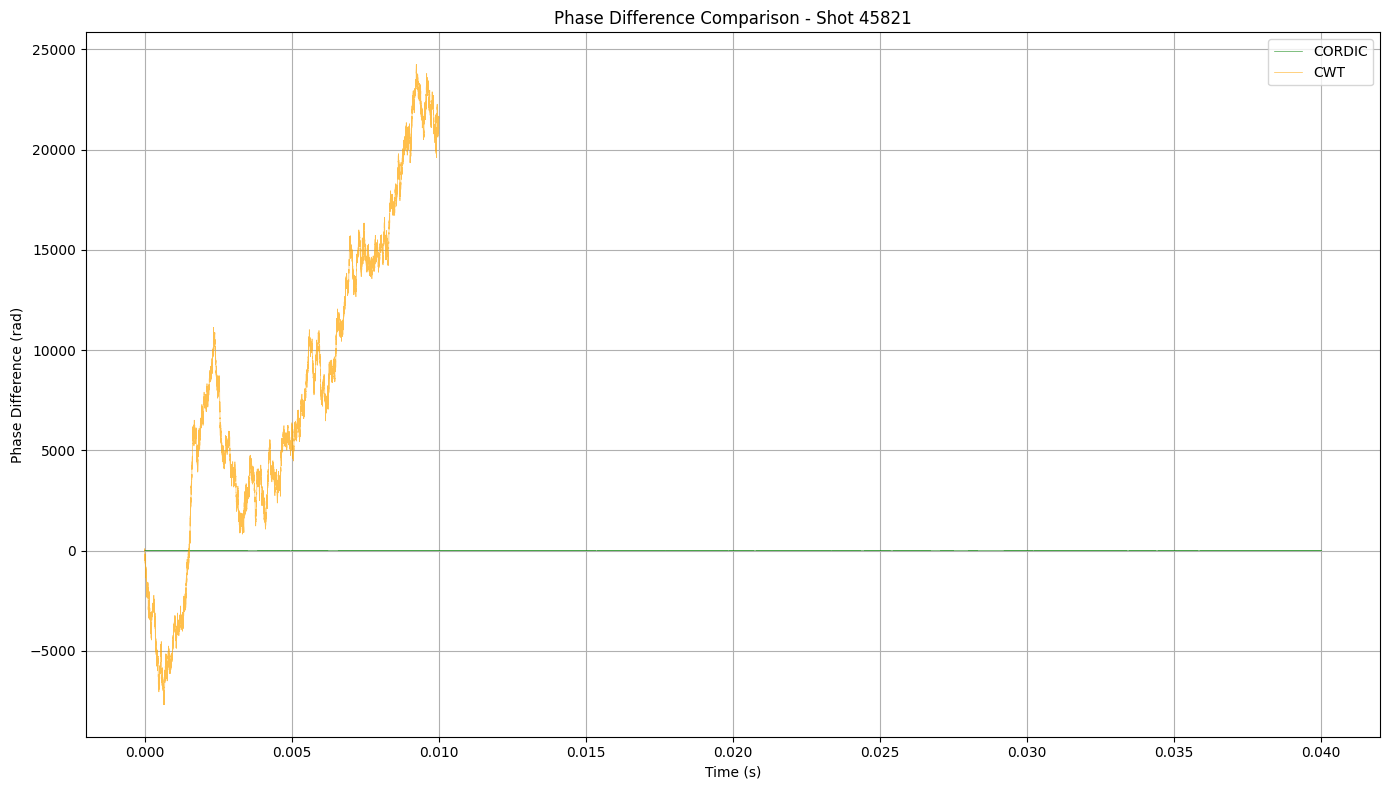


✓ Method comparison complete


In [8]:
print("=" * 80)
print("Method Comparison")
print("=" * 80)

# Collect all successful results
methods_data = {}

if cdm_success and phase_diff_cdm is not None:
    time_cdm = np.arange(len(phase_diff_cdm)) / fs
    methods_data["CDM"] = {"time": time_cdm, "phase": phase_diff_cdm}
    
if cordic_success and phase_diff_cordic is not None:
    methods_data["CORDIC"] = {"time": times_cordic, "phase": phase_diff_cordic}
    
if stft_success and phase_diff_stft is not None:
    methods_data["STFT"] = {"time": t_common, "phase": phase_diff_stft}
    
if cwt_success and phase_diff_cwt is not None:
    methods_data["CWT"] = {"time": t_cwt, "phase": phase_diff_cwt}

print(f"\nSuccessful methods: {list(methods_data.keys())}")

# Compare statistics
print("\nMethod Statistics:")
print("-" * 80)
for method_name, data in methods_data.items():
    phase = data["phase"]
    print(f"{method_name}:")
    print(f"  Mean: {np.mean(phase):.4f} rad ({np.mean(phase)*180/np.pi:.2f} deg)")
    print(f"  Std: {np.std(phase):.4f} rad")
    print(f"  Range: [{np.min(phase):.4f}, {np.max(phase):.4f}] rad")
    print()

# Visualize all methods together
if methods_data:
    plt.figure(figsize=(14, 8))
    
    colors = {"CDM": "blue", "CORDIC": "green", "STFT": "red", "CWT": "orange"}
    
    for method_name, data in methods_data.items():
        color = colors.get(method_name, "gray")
        plt.plot(data["time"], data["phase"], label=method_name, alpha=0.7, linewidth=0.5, color=color)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Phase Difference (rad)")
    plt.title(f"Phase Difference Comparison - Shot {shot_num}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n✓ Method comparison complete")


## Summary

Review the results above to assess:
- Method consistency and agreement
- Signal quality and noise characteristics
- Phase difference trends and patterns
- Performance of each method on real experimental data


# Phase Analysis with Real Data

This notebook tests phase analysis components using actual experimental data.

## Purpose:
- Load real shot data from NAS_DB
- Test phase analysis methods (SignalStacker, STFTRidgeAnalyzer, CWTPhaseReconstructor) on real data
- Compare results with synthetic data tests
- Validate robustness with actual experimental conditions

## Usage:
1. Set the shot number in the configuration cell below
2. Run cells sequentially to load data and perform analysis
3. Inspect results, visualizations, and compare with expected behavior


## 1. Setup and Configuration


In [9]:
# Setup and imports
import sys
from pathlib import Path
import os

# Configure Numba threading layer for parallel execution
os.environ['NUMBA_THREADING_LAYER'] = 'tbb'

# Add project root to path
current_dir = Path.cwd()
ifi_root = current_dir.parent if current_dir.name == "analysis" else current_dir
sys.path.insert(0, str(ifi_root))

from ifi.utils.cache_setup import setup_project_cache
cache_config = setup_project_cache()
print(f"Cache configured: {cache_config['cache_dir']}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from typing import Dict, Any, Optional

# Import Numba config after setting environment variable
try:
    import numba
    try:
        numba.config.THREADING_LAYER = 'tbb'
        print(f"Numba threading layer: {numba.config.THREADING_LAYER}")
    except Exception as e:
        print(f"Warning: Could not set Numba threading layer: {e}")
except ImportError:
    print("Warning: Numba not available")

from ifi.db_controller.nas_db import NAS_DB
from ifi.db_controller.vest_db import VEST_DB
from ifi.analysis.phase_analysis import (
    SignalStacker,
    STFTRidgeAnalyzer,
    CWTPhaseReconstructor,
    PhaseChangeDetector,
)
from ifi.analysis.phi2ne import get_interferometry_params
from ifi.analysis import processing

print("✓ All imports successful")


Cache configured: C:\Users\dhkdw\Documents\mygit\ifi\cache\numba_cache
Numba threading layer: tbb
✓ All imports successful


In [10]:
# Configuration: Set shot number and file selection
SHOT_NUMBER = 45821  # Change this to test different shots
FILE_SELECTION = None  # None = use first file, or specify filename pattern like "_ALL" or "_056"

# Analysis parameters
USE_OFFSET_REMOVAL = True
OFFSET_WINDOW = 1000

print(f"Configuration:")
print(f"  Shot number: {SHOT_NUMBER}")
print(f"  File selection: {FILE_SELECTION if FILE_SELECTION else 'First available file'}")
print(f"  Offset removal: {USE_OFFSET_REMOVAL}")
print(f"  Offset window: {OFFSET_WINDOW}")


Configuration:
  Shot number: 45821
  File selection: First available file
  Offset removal: True
  Offset window: 1000


## 2. Initialize Database Connections and Load Real Data


In [11]:
# Initialize database connections
print("Initializing database connections...")
nas_db = NAS_DB()
vest_db = VEST_DB()

print(f"✓ NAS_DB initialized")
print(f"✓ VEST_DB initialized")

# Find and load shot data
print(f"\nFinding files for shot {SHOT_NUMBER}...")
target_files = nas_db.find_files(query=SHOT_NUMBER)

if not target_files:
    print(f"⚠ No files found for shot {SHOT_NUMBER}")
    print("Please check the shot number or database connection.")
    target_file = None
else:
    print(f"✓ Found {len(target_files)} file(s) for shot {SHOT_NUMBER}")
    for i, file_path in enumerate(target_files):
        print(f"  {i+1}. {Path(file_path).name}")
    
    # Select file based on FILE_SELECTION
    if FILE_SELECTION:
        selected_file = next((f for f in target_files if FILE_SELECTION in Path(f).name), None)
        if selected_file:
            target_file = selected_file
            print(f"\n✓ Selected file: {Path(target_file).name}")
        else:
            print(f"\n⚠ File pattern '{FILE_SELECTION}' not found, using first file")
            target_file = target_files[0]
    else:
        target_file = target_files[0]
        print(f"\n✓ Using first file: {Path(target_file).name}")

# Load actual data
if target_file:
    print(f"\nLoading data from: {Path(target_file).name}")
    data_dict = nas_db.get_shot_data(target_file, force_remote=False)
    
    if not data_dict or target_file not in data_dict:
        print(f"⚠ Failed to load data from {target_file}")
        df_raw = None
    else:
        df_raw = data_dict[target_file]
        print(f"✓ Data loaded successfully")
        print(f"\nDataFrame info:")
        print(f"  Shape: {df_raw.shape}")
        print(f"  Columns: {list(df_raw.columns)}")
        print(f"  Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        print(f"  Time range: [{df_raw['TIME'].min():.6f}, {df_raw['TIME'].max():.6f}] s")
        
        # Check for NaN values
        nan_counts = df_raw.isna().sum()
        if nan_counts.sum() > 0:
            print(f"\n⚠ NaN values found:")
            for col, count in nan_counts.items():
                if count > 0:
                    print(f"  {col}: {count} ({count/len(df_raw)*100:.2f}%)")
        else:
            print(f"\n✓ No NaN values found")
else:
    df_raw = None
    print("⚠ Cannot load data - no target file")


Initializing database connections...
✓ NAS_DB initialized
✓ VEST_DB initialized

Finding files for shot 45821...
✓ Found 3 file(s) for shot 45821
  1. 45821_056.csv
  2. 45821_789.csv
  3. 45821_ALL.csv

✓ Using first file: 45821_056.csv

Loading data from: 45821_056.csv
✓ Data loaded successfully

DataFrame info:
  Shape: (10000000, 4)
  Columns: ['TIME', 'CH0', 'CH1', 'CH2']
  Memory usage: 381.47 MB
  Time range: [-0.010000, 0.030000] s

✓ No NaN values found
